# ResNet Model Implementation

Based on the following paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

### Implementation Detail:
The implementation made in this program follows the original paper closely but added the following modern techniques:
1. Adam optimizer
2. LeakyReLU activation function
3. Batch Normalization

### Architecture
![ResNet Architecture](resnet_architecture.png)

### Dataset

Uses Imagenette (a smaller subset of The ImageNet dataset) available from [fastai](https://github.com/fastai/imagenette) or [pytorch](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html)  
Imagenette consists of images with the following class label
```
        "n01440764": ("tench", "Tinca tinca"),
        "n02102040": ("English springer", "English springer spaniel"),
        "n02979186": ("cassette player",),
        "n03000684": ("chain saw", "chainsaw"),
        "n03028079": ("church", "church building"),
        "n03394916": ("French horn", "horn"),
        "n03417042": ("garbage truck", "dustcart"),
        "n03425413": ("gas pump", "gasoline pump", "petrol pump", "island dispenser"),
        "n03445777": ("golf ball",),
        "n03888257": ("parachute", "chute"),
```

## Code

## Loading Libraries

In [1]:
# Top level package
import torch
import torchvision

# Image augmentation operations
from torchvision.transforms import v2

# NN-layers
from torch import nn

# Activation functions
import torch.nn.functional as F

# Optimizers
import torch.optim as optim

# Data reader and loader
from torch.utils.data import TensorDataset, DataLoader, Subset

# Evaluation suite
import torchmetrics

# Imagenette utils
from torchvision.datasets import Imagenette

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# numpy
import numpy as np

# pandas
import pandas as pd

# sklearn for stratified split
from sklearn.model_selection import train_test_split

# tensorboard for monitoring and versioning
from tensorboardX import SummaryWriter

# torch summary for keras style architecture summary
from torchsummary import summary

# setting random seed for replicability
torch.manual_seed(42)

## Loading & Reading Dataset

### Defining Image Augmentations

In [2]:
# autoaugment policy from https://arxiv.org/abs/1805.09501 
# https://pytorch.org/vision/main/generated/torchvision.transforms.v2.AutoAugment.html

# policy = v2.AutoAugmentPolicy.IMAGENET

# resize to 224 x 224 -> autoaugment -> turn to tensor
# custom_transforms = v2.Compose([
#     v2.Resize(size=(224, 224)),
#     v2.AutoAugment(policy=policy),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True)
# ])

# simple rotation and contrast transform
custom_transforms = v2.Compose([
    v2.Resize(size = (224,224)),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomVerticalFlip(p = 0.5),
    v2.RandomAutocontrast(p = 0.5),
    v2.ToTensor()
])

convert_to_tensor = v2.Compose([
    v2.Resize(size=(224, 224)),
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True)
    v2.ToTensor()
])

e:\Current_Workdir\Portfolios\CNN-on-Imagenette\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


### Loading Training and Testing Data

In [3]:
train_filepath = "../../dataset/imagenette2/train"
test_filepath = "../../dataset/imagenette2/val"

In [4]:
# imagenette_train = Imagenette(filepath, split="train", transform=custom_transforms, download=False)
# imagenette_test = Imagenette(filepath, split="val", transform=convert_to_tensor, download=False)

imagenette_train = torchvision.datasets.ImageFolder(train_filepath, transform= custom_transforms)
imagenette_test = torchvision.datasets.ImageFolder(test_filepath, transform=convert_to_tensor)

### Creating Training/Validation/Testing Split

In [5]:
train_idx, val_idx, _, _ = train_test_split(
    range(len(imagenette_train)),
    imagenette_train.targets,
    stratify=imagenette_train.targets,
    test_size=0.1,
    random_state=42
)

In [6]:
imagenette_train = Subset(imagenette_train, train_idx)
imagenette_valid = Subset(imagenette_train, val_idx)

### Creating Data Loader

In [7]:
batch_size = 64

In [8]:
train_dataloader = DataLoader(imagenette_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(imagenette_valid.dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(imagenette_test, batch_size=batch_size, shuffle=True)

### Inspecting Sample Data

In [9]:
label_dict = {
    0: "tench",
    1: "English springer",
    2: "cassette player",
    3: "chain saw",
    4: "church",
    5: "French horn",
    6: "garbage truck",
    7: "gas pump",
    8: "golf ball",
    9: "parachute"
}

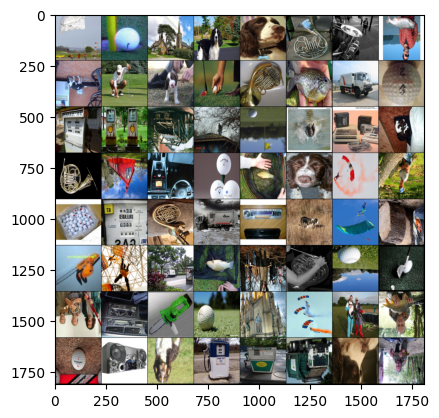

['parachute', 'golf ball', 'church', 'English springer', 'English springer', 'French horn', 'French horn', 'tench', 'English springer', 'golf ball', 'English springer', 'golf ball', 'French horn', 'tench', 'garbage truck', 'golf ball', 'gas pump', 'gas pump', 'garbage truck', 'chain saw', 'golf ball', 'English springer', 'cassette player', 'English springer', 'French horn', 'church', 'cassette player', 'golf ball', 'tench', 'English springer', 'parachute', 'chain saw', 'golf ball', 'gas pump', 'French horn', 'garbage truck', 'cassette player', 'English springer', 'parachute', 'chain saw', 'chain saw', 'parachute', 'garbage truck', 'tench', 'chain saw', 'French horn', 'golf ball', 'golf ball', 'French horn', 'cassette player', 'chain saw', 'golf ball', 'church', 'parachute', 'parachute', 'tench', 'golf ball', 'cassette player', 'English springer', 'gas pump', 'gas pump', 'garbage truck', 'English springer', 'tench']


In [10]:
# Training Data
# get some random training images
train_dataiter = iter(train_dataloader)
train_images, train_labels = next(train_dataiter)

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(train_images))
# print labels
print([label_dict[train_labels[j].item()] for j in range(batch_size)])

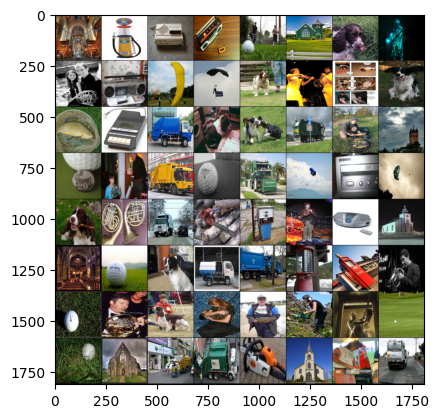

['church', 'gas pump', 'cassette player', 'cassette player', 'golf ball', 'church', 'English springer', 'French horn', 'French horn', 'cassette player', 'parachute', 'parachute', 'English springer', 'French horn', 'English springer', 'English springer', 'tench', 'cassette player', 'garbage truck', 'English springer', 'English springer', 'garbage truck', 'tench', 'church', 'golf ball', 'French horn', 'garbage truck', 'golf ball', 'garbage truck', 'parachute', 'cassette player', 'parachute', 'English springer', 'French horn', 'garbage truck', 'chain saw', 'gas pump', 'French horn', 'cassette player', 'church', 'church', 'golf ball', 'English springer', 'garbage truck', 'garbage truck', 'gas pump', 'gas pump', 'French horn', 'golf ball', 'French horn', 'English springer', 'French horn', 'tench', 'chain saw', 'chain saw', 'golf ball', 'golf ball', 'church', 'garbage truck', 'garbage truck', 'chain saw', 'church', 'chain saw', 'garbage truck']


In [11]:
# Testing Data
# get some random testing images
test_dataiter = iter(test_dataloader)
test_images, test_labels = next(test_dataiter)

# show images
imshow(torchvision.utils.make_grid(test_images))
# print labels
print([label_dict[test_labels[j].item()] for j in range(batch_size)])

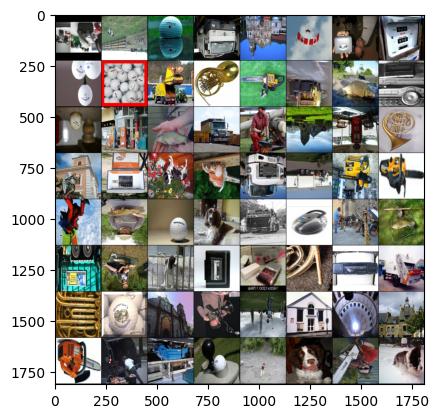

['cassette player', 'English springer', 'golf ball', 'garbage truck', 'church', 'parachute', 'cassette player', 'gas pump', 'golf ball', 'golf ball', 'garbage truck', 'French horn', 'chain saw', 'garbage truck', 'tench', 'cassette player', 'golf ball', 'gas pump', 'tench', 'garbage truck', 'chain saw', 'church', 'gas pump', 'French horn', 'church', 'gas pump', 'English springer', 'chain saw', 'garbage truck', 'garbage truck', 'chain saw', 'chain saw', 'parachute', 'tench', 'golf ball', 'English springer', 'garbage truck', 'cassette player', 'French horn', 'tench', 'garbage truck', 'tench', 'English springer', 'cassette player', 'cassette player', 'French horn', 'cassette player', 'garbage truck', 'French horn', 'golf ball', 'church', 'French horn', 'golf ball', 'church', 'church', 'church', 'chain saw', 'garbage truck', 'garbage truck', 'golf ball', 'English springer', 'English springer', 'chain saw', 'English springer']


In [12]:
# validation Data
# get some random validation images
val_dataiter = iter(val_dataloader)
val_images, val_labels = next(val_dataiter)

# show images
imshow(torchvision.utils.make_grid(val_images))
# print labels
print([label_dict[val_labels[j].item()] for j in range(batch_size)])

## Configuring Device

In [13]:
# use GPU if available, if not then use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Defining Model

### Model Architecture

In [18]:
# Residual Block Architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.downsample = downsample
        self.leaky_relu = nn.LeakyReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        out = self.leaky_relu(out)
        return out


# Module Architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_target_class):
        super().__init__()
        
        self.inplanes = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.linear = nn.Linear(512, num_target_class)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        
        if (stride != 1) or (self.inplanes != planes):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(planes, planes))  # Fixed this line
        
        return nn.Sequential(*layers)
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [19]:
# Instantiating resnet34, 3 residual blocks -> 4 residual blocks -> 6 residual blocks -> 3 residual blocks
net = ResNet(block = ResidualBlock, layers = [3, 4, 6, 3], num_target_class = 10)

### Loss Function

In [20]:
loss_function = nn.CrossEntropyLoss()
loss_function

CrossEntropyLoss()

### Optimizer

In [21]:
learning_rate = 0.001

In [22]:
# define the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [23]:
gamma = 1

In [24]:
# define the learning rate scheduler
# exponential decay learning rate
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
lr_scheduler

### Metric

In [25]:
# define eval metrics
# multiclass accuracy top-1
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, top_k = 1)
metric.to(device)

MulticlassAccuracy()

## Training

### Loading Model to Device

In [26]:
net.to(device)
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         LeakyReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
         LeakyReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
        LeakyReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
        LeakyReLU-14           [-1, 64,

### Training Loop

In [27]:
# specify number of epoch
num_epoch = 10

In [28]:
# initialize tensorboard
writer = SummaryWriter()

In [29]:
train_loss = []
val_loss = []
val_acc = []
lr = []

In [30]:
for epoch in range(num_epoch):
    
    net.train()
    for data in train_dataloader:
        # move data to device
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the gradient parameters
        optimizer.zero_grad()
        
        # forward propagation
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        
        # backward propagation
        loss.backward()
        optimizer.step()

    # saving the current learning rate
    lr.append(optimizer.param_groups[0]["lr"])
    writer.add_scalar('/lr', optimizer.param_groups[0]["lr"], epoch)
    
    # stepping the lr scheduler
    lr_scheduler.step()
    
    # save training loss for visualization
    train_loss.append(loss.item())
    writer.add_scalar('Loss/Train', loss.item(), epoch)
    print('Epoch [{}/{}] Training, Loss: {:.4f}'.format(epoch+1, num_epoch, loss.item()))

    # calculating validation loss & accuracy
    net.eval()
    for data in val_dataloader:
        # move validation data to device
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # get prediction
        predictions = net(inputs)
        
        # compute validation accuraccy
        acc = metric(labels, predictions.argmax(dim=-1))
        
        # compute validation loss
        loss = loss_function(predictions, labels)
    
    # save validation loss for visualization
    accuracy = metric.compute()
    val_loss.append(loss.item())
    writer.add_scalar('Loss/Validation', loss.item(), epoch)
    val_acc.append(accuracy.item())
    writer.add_scalar('Acc/Validation', accuracy.item(), epoch)
    print('Epoch [{}/{}] Validation, Loss: {:.4f}, Acc : {:.4f}'.format(epoch+1, num_epoch, loss.item(), accuracy))
    
    # save the histogram of the gradient
    for name, param in net.named_parameters():
        writer.add_histogram(name + '/grad', param.grad, epoch)
        
print('Training Loop Finished')

Epoch [1/10] Training, Loss: 1.8622
Epoch [1/10] Validation, Loss: 2.8605, Acc : 0.2661
Epoch [2/10] Training, Loss: 1.5168
Epoch [2/10] Validation, Loss: 1.8202, Acc : 0.3313
Epoch [3/10] Training, Loss: 1.2166
Epoch [3/10] Validation, Loss: 1.1842, Acc : 0.3611
Epoch [4/10] Training, Loss: 1.9136
Epoch [4/10] Validation, Loss: 3.6636, Acc : 0.3413
Epoch [5/10] Training, Loss: 2.0924
Epoch [5/10] Validation, Loss: 2.0764, Acc : 0.3675
Epoch [6/10] Training, Loss: 1.3030
Epoch [6/10] Validation, Loss: 3.1117, Acc : 0.3526
Epoch [7/10] Training, Loss: 0.8087
Epoch [7/10] Validation, Loss: 1.2190, Acc : 0.3925
Epoch [8/10] Training, Loss: 0.3636
Epoch [8/10] Validation, Loss: 2.3264, Acc : 0.3818
Epoch [9/10] Training, Loss: 0.7851
Epoch [9/10] Validation, Loss: 1.4445, Acc : 0.4148
Epoch [10/10] Training, Loss: 1.7508
Epoch [10/10] Validation, Loss: 0.6817, Acc : 0.4375
Training Loop Finished


### Visualizing Loss and Accuracy

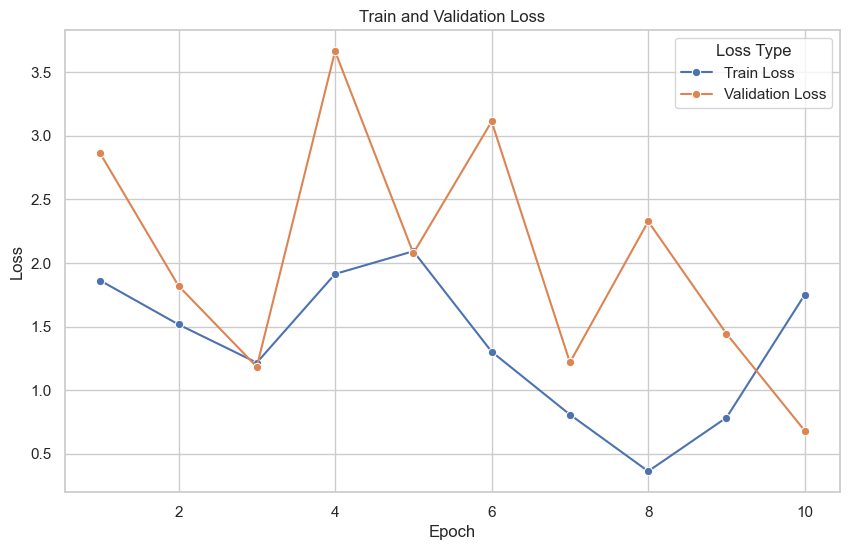

In [31]:
# Plotting Validation and Training Loss 
data = pd.DataFrame({'Epoch': range(1, len(train_loss) + 1),
                     'Train Loss': train_loss,
                     'Validation Loss': val_loss})

data_melted = pd.melt(data, id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Loss', hue='Loss Type', data=data_melted, marker='o')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Loss Type')
plt.show()

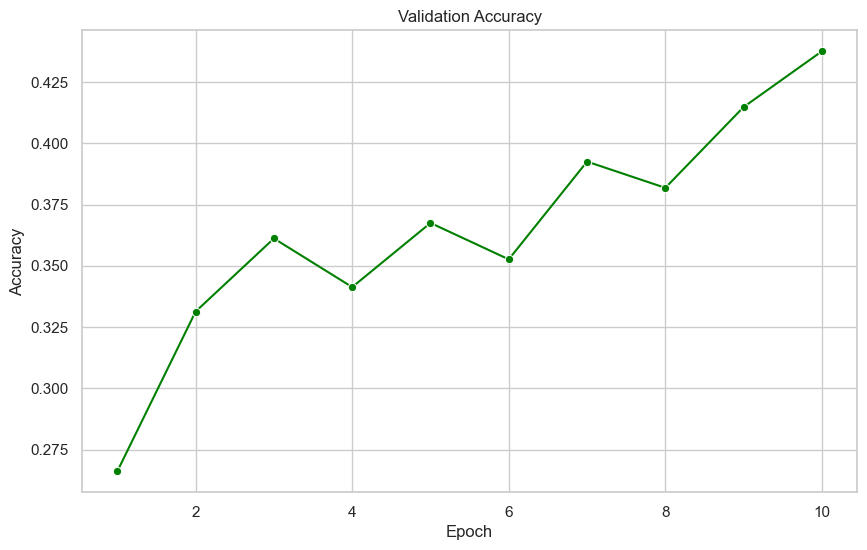

In [32]:
# Plotting Validation Accuracy
data_acc = pd.DataFrame({'Epoch': range(1, len(val_acc) + 1),
                         'Validation Accuracy': val_acc})

plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Validation Accuracy', data=data_acc, marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Visualizing Learning Rate

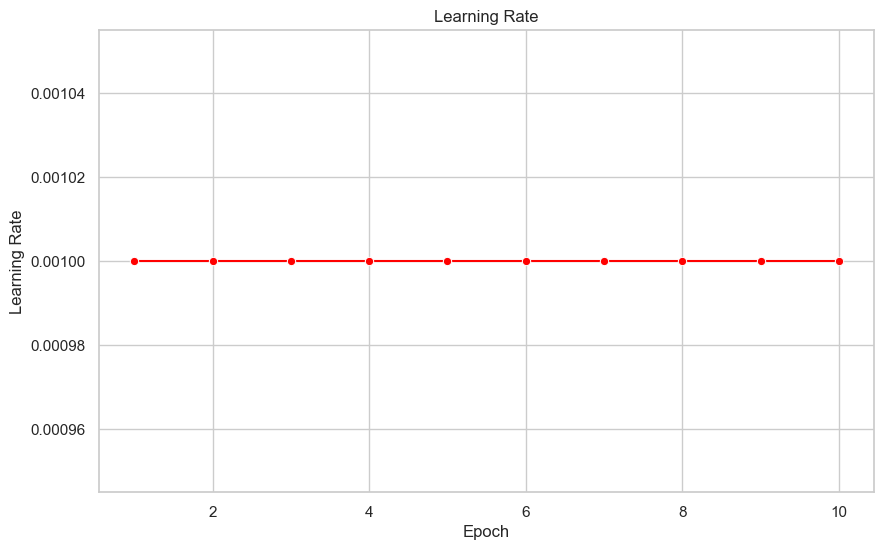

In [33]:
# Plotting Learning Rate
data_lr = pd.DataFrame({'Epoch': range(1, len(lr) + 1),
                         'Learning Rate': lr})

plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Learning Rate', data=data_lr, marker='o', color='red')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

### Saving Model

In [34]:
path = r".\resnet34_imagenette.pth"

In [35]:
torch.save(net.state_dict(), path)

## Testing Loop

In [36]:
net.eval()
    
for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    predictions = net(inputs)
    accuracy = metric(labels, predictions.argmax(dim=-1))
    
accuracy = metric.compute()
writer.add_scalar('Accuracy/Test', accuracy, num_epoch)
print(f"Accuracy on test data: {accuracy}")

Accuracy on test data: 0.4453979432582855
